* Grab TRD loci of all crosses
* do the SNPRelate phylogeny for each locus

In [1]:
library(data.table)
library(tidytable)
library(ggplot2)


Attaching package: 'tidytable'


The following objects are masked from 'package:data.table':

    between, first, fread, last


The following objects are masked from 'package:stats':

    dt, filter, lag


The following object is masked from 'package:base':

    %in%




In [2]:
library(SNPRelate)
library(ape)

# Get paths of input files
my.vcf <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
subset_samples = "none"

if(subset_samples == "none"){
    subset_samples=NULL
    prefix <- basename(my.vcf)
    }else{
    prefix <- basename(subset_samples)
    subset_samples=readLines(subset_samples)
    }

setwd(dirname(my.vcf))
if(!file.exists(paste0(prefix, ".gds"))){
    snpgdsVCF2GDS(my.vcf, paste0(prefix, ".gds"), ignore.chr.prefix="chromosome")
}

Loading required package: gdsfmt

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)


Attaching package: 'ape'


The following object is masked from 'package:tidytable':

    where




In [3]:
genofile <- snpgdsOpen(paste0(prefix, ".gds"))


In [4]:
if(!file.exists("pca_global.rds")){
    pca_global <- snpgdsPCA(genofile, num.thread=1)
    saveRDS(pca_global, file = "pca_global.rds")
}else{
    pca_global=readRDS(file = "pca_global.rds")
}
pca_global.percent <- pca_global$varprop*100
head(round(pca_global.percent, 2))

tab_global <- data.frame(sample.id = pca_global$sample.id,
    EV1 = pca_global$eigenvect[,1],    # the first eigenvector
    EV2 = pca_global$eigenvect[,2],    # the second eigenvector
    stringsAsFactors = FALSE)

[1] 4.92 2.52 1.77 1.54 1.50 1.46

In [5]:
if(!file.exists("tab_ibs_global.rds")){
    ibs <- snpgdsIBS(genofile, num.thread=1)
    loc <- cmdscale(1 - ibs$ibs, k = 2)
    x <- loc[, 1]; y <- loc[, 2]
    tab_ibs_global <- data.frame(sample.id = ibs$sample.id,
                MDS1 = x,    # the first eigenvector
                MDS2 = y,    # the second eigenvector
                stringsAsFactors = FALSE)
    saveRDS(tab_ibs_global, file = "tab_ibs_global.rds")
}else{
    tab_ibs_global=readRDS(file = "tab_ibs_global.rds")
}

In [101]:
if(!file.exists("diss_global.rds")){
    dissMatrix <- snpgdsDiss(genofile, num.thread = 1)
    saveRDS(dissMatrix, "diss_global.rds")
    }else{
    dissMatrix=readRDS(file = "diss_global.rds")
}

In [103]:
?snpgdsDiss

snpgdsDiss {SNPRelate},R Documentation
gdsobj,"an object of class SNPGDSFileClass, a SNP GDS file"
sample.id,"a vector of sample id specifying selected samples; if NULL, all samples are used"
snp.id,"a vector of snp id specifying selected SNPs; if NULL, all SNPs are used"
autosome.only,"if TRUE, use autosomal SNPs only; if it is a numeric or character value, keep SNPs according to the specified chromosome"
remove.monosnp,"if TRUE, remove monomorphic SNPs"
maf,"to use the SNPs with "">= maf"" only; if NaN, no MAF threshold"
missing.rate,"to use the SNPs with ""<= missing.rate"" only; if NaN, no missing threshold"
num.thread,"the number of (CPU) cores used; if NA, detect the number of cores automatically"
verbose,"if TRUE, show information"
sample.id,the sample ids used in the analysis


In [59]:
if(!file.exists("diss_global.newick")){
    colnames(dissMatrix$diss) <- dissMatrix$sample.id
    tr <- bionjs(dissMatrix$diss)
    write.tree(tr, file = "diss_global.newick", append = FALSE,digits = 10, tree.names = FALSE)
}else{
    tr=ape::read.tree("diss_global.newick")
}

In [84]:
library(stringr)
crosses_xlsx=readxl::read_xlsx("~/data/trd/Crosses.xlsx", sheet=2)
cc=data.frame("Cross ID"=c(paste0("ChrisC",1:8)),
                                  "Short name 1"=c("ACP","BAP","CCD","ATE","ACK","AKE","BAH","ANG"),
                                  "Short name 2"=c("BFP","CMP","CPG","SACE_YCR","ACV","BAH","CGD","CEI"), stringsAsFactors=FALSE)
colnames(cc)=str_replace_all(colnames(cc), fixed("."), " ")
crosses_xlsx <- bind_rows(crosses_xlsx[,c("Cross ID","Short name 1","Short name 2")],
                        cc)
head(crosses_xlsx)
tail(crosses_xlsx)

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


Cross ID,Short name 1,Short name 2
<chr>,<chr>,<chr>
YJNRC1,BAK,BET
YJNRC2,BAN,BTI
YJNRC3,AKH,BQC
YJNRC4,ABS,BEF
YJNRC5,BAK,BMK
YJNRC6,BAN,CRB


Cross ID,Short name 1,Short name 2
<chr>,<chr>,<chr>
ChrisC3,CCD,CPG
ChrisC4,ATE,SACE_YCR
ChrisC5,ACK,ACV
ChrisC6,AKE,BAH
ChrisC7,BAH,CGD
ChrisC8,ANG,CEI


In [86]:
all_strains_used<-unique(c(crosses_xlsx$`Short name 1`,crosses_xlsx$`Short name 2`))
head(all_strains_used)

[1] "BAK" "BAN" "AKH" "ABS" "AMM" "ABE"

In [93]:
summary(tr$tip.label %in% all_strains_used)

   Mode   FALSE    TRUE 
logical    2432      57 

In [99]:
used_strains_in_tree<-c(tr$tip.label %in% all_strains_used,rep(NA,4976-2489))

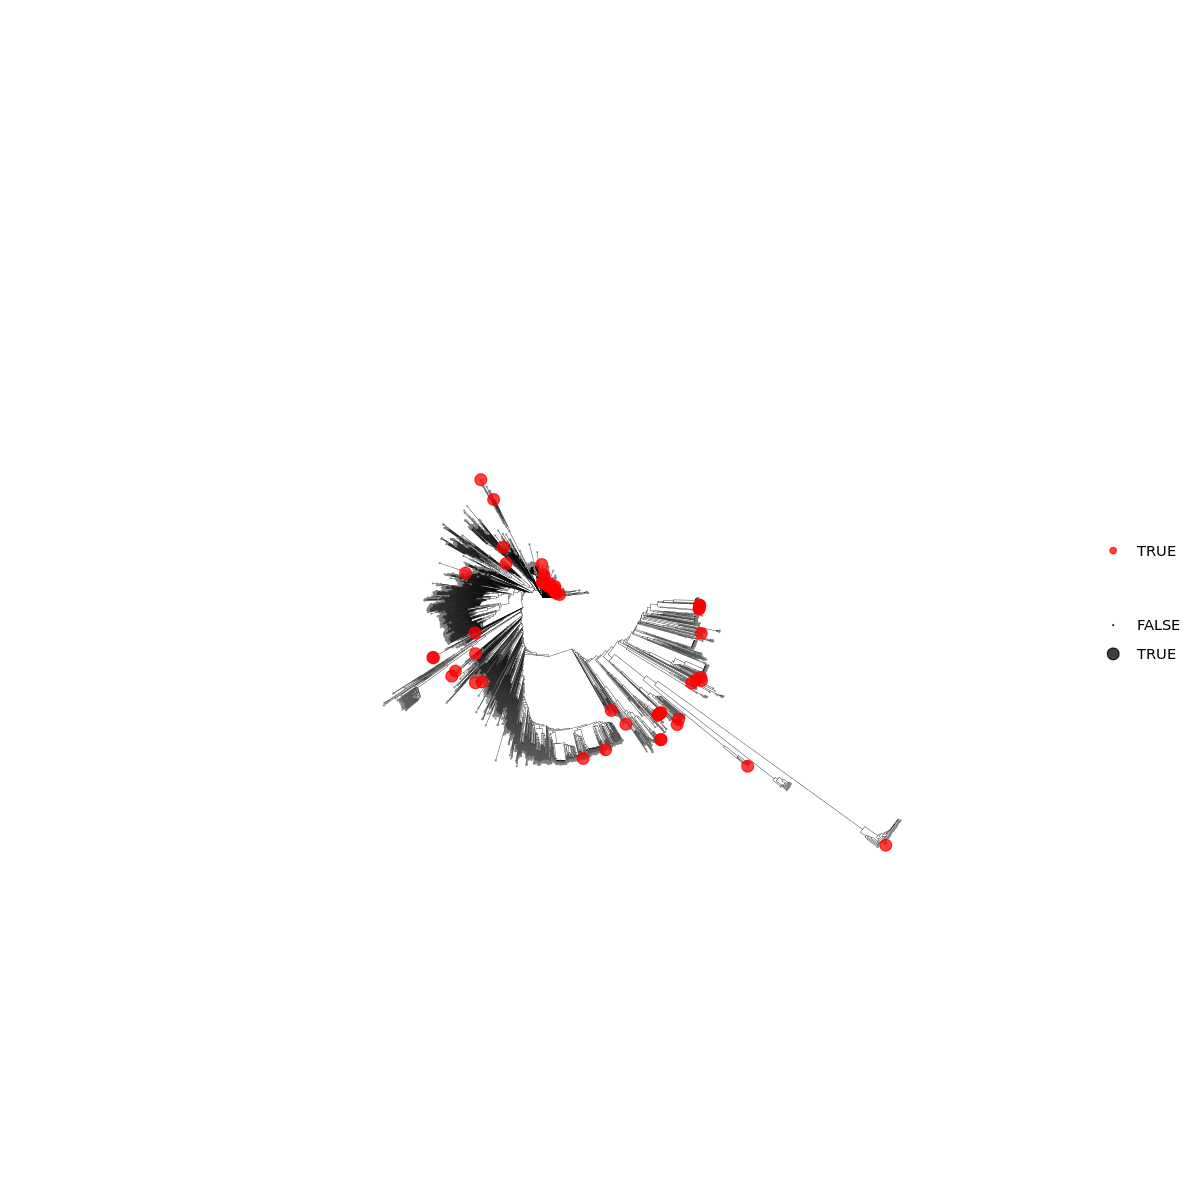

In [100]:
library(ggtree)
options(repr.plot.width=10, repr.plot.height=10)
ggtree::ggtree(tr, layout="circular", size=0.1)+
geom_tippoint(aes(color=used_strains_in_tree,
                 size=used_strains_in_tree), alpha=.75)+
scale_color_manual(values=c("TRUE"="red"))+
scale_size_manual(values=c("TRUE"=3,"FALSE"=0,"NA"=0))+labs(size=NULL,color=NULL)

In [16]:
chrpos<-data.table(chr=read.gdsn(index.gdsn(genofile, "snp.chromosome")), pos=read.gdsn(index.gdsn(genofile, "snp.position")))

closest_value <- function(vec, x) {
  vec[which.min(abs(vec - x))]
}


get_position=function(chrpos,x, size=50000){
    starting_point<-x
    # widen the window to size/2 on in both directions
    row_used<-slice(chrpos, starting_point)
    chr_subset<-filter(chrpos, chr==pull(row_used, chr))
    
    to_pos<-pull(row_used, pos)+(size/2)
    from_pos<-pull(row_used, pos)-(size/2)
    
    
    to_pos<-closest_value(pull(chr_subset, pos), to_pos)
    from_pos<-closest_value(pull(chr_subset, pos), from_pos)
    
    size_real<-to_pos-from_pos
    
    if(size_real<size & to_pos == max(pull(chr_subset, pos))){
        from_pos<-from_pos-(size-size_real)
        from_pos<-closest_value(pull(chr_subset, pos), from_pos)
    }
    
    if(size_real<size & from_pos == min(pull(chr_subset, pos))){
        to_pos<-to_pos+(size-size_real)
        to_pos<-closest_value(pull(chr_subset, pos), to_pos)
    }
    
    return(data.table(chr=pull(row_used, chr), from=from_pos, to=to_pos))
    
}

In [18]:
# get a list of 1,000 random regions, each group should be 50kB
set.seed(1337)
rng<-sample(1:nrow(chrpos), 10000)
rng<-bind_rows(lapply(rng, get_position, chrpos=chrpos, size=50000))

head(rng)

chr,from,to
<chr>,<int>,<int>
5,451702,501706
8,510133,560131
12,1022666,1072666
10,522692,572690
7,875903,925901
10,194592,244592


ERROR: Error in eval(expr, envir, enclos): This needs to be done


In [23]:
euclidean_distance <- function(x, y) {
  sqrt(x^2 + y^2)
}


In [ ]:
# needs to be parallelized

In [ ]:
PCA_distances_from_0=list()
IBS_MDS_distances_from_0=list()
rng_trees<-list()
rng_tree_distances<-list()

for(i in 1:nrow(rng)){
    
    if(length(rng_tree_distances[[i]]) > 0) {
          next
    }

    rng_row<-slice(rng,i)

    snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))>=pull(rng_row,from)&
                 read.gdsn(index.gdsn(genofile, "snp.position"))<=pull(rng_row,to)&
                 read.gdsn(index.gdsn(genofile, "snp.chromosome"))==pull(rng_row,chr))

    head(snpset)

    # generate PCA, IBS, and tree for the random regions

    pca_rng <- snpgdsPCA(genofile, num.thread=1, snp.id = snpset)

    x<-pca_rng$eigenvect[,1]
    y<-pca_rng$eigenvect[,2]

    PCA_distances_from_0[[i]]<-euclidean_distance(x,y)


    # IBS

    ibs <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
    loc <- cmdscale(1 - ibs$ibs, k = 2)

    x <- loc[, 1]
    y <- loc[, 2]

    IBS_MDS_distances_from_0[[i]]<-euclidean_distance(x,y)

    # tree

    dissMatrix_rng <- snpgdsDiss(genofile, snp.id=snpset, num.thread = 1)
    colnames(dissMatrix_rng$diss) <- dissMatrix_rng$sample.id
    tr <- bionjs(dissMatrix_rng$diss)
    rng_trees[[i]]<-tr
    rng_tree_distances[[i]]<-ape::cophenetic.phylo(tr)

    # save each and check whether it was done rather than redoing it

    # these will then serve as the distributions of PCA/IBS two-dimensional distance from mean/median/center in global vs local? and some way of quantifying tree distance to global tree

    # check if distributions are normal

    # then we can check each value against this distribution and we can see if the TRD region is particularly different
    
    }

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


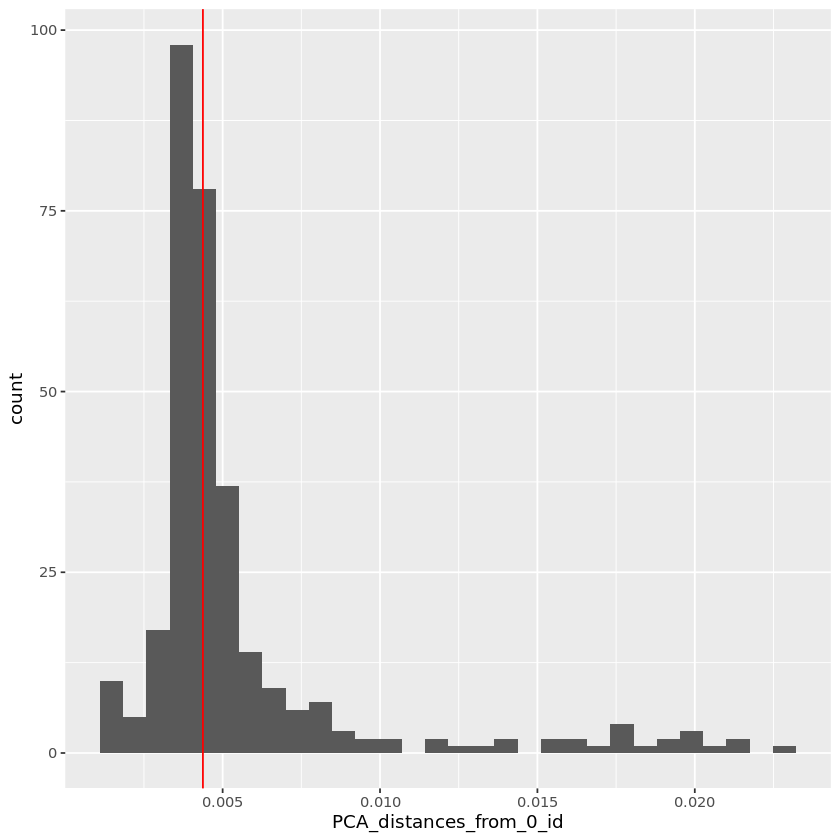

In [49]:
id=1
trd_region=PCA_distances_from_0[[300]] # this should be its own object, calculated just before

PCA_distances_from_0_id<-extracted_elements <- purrr::map(PCA_distances_from_0, id)%>%unlist()

ggplot(mapping=aes(PCA_distances_from_0_id))+
geom_histogram()+
geom_vline(xintercept = trd_region[id], color="red")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


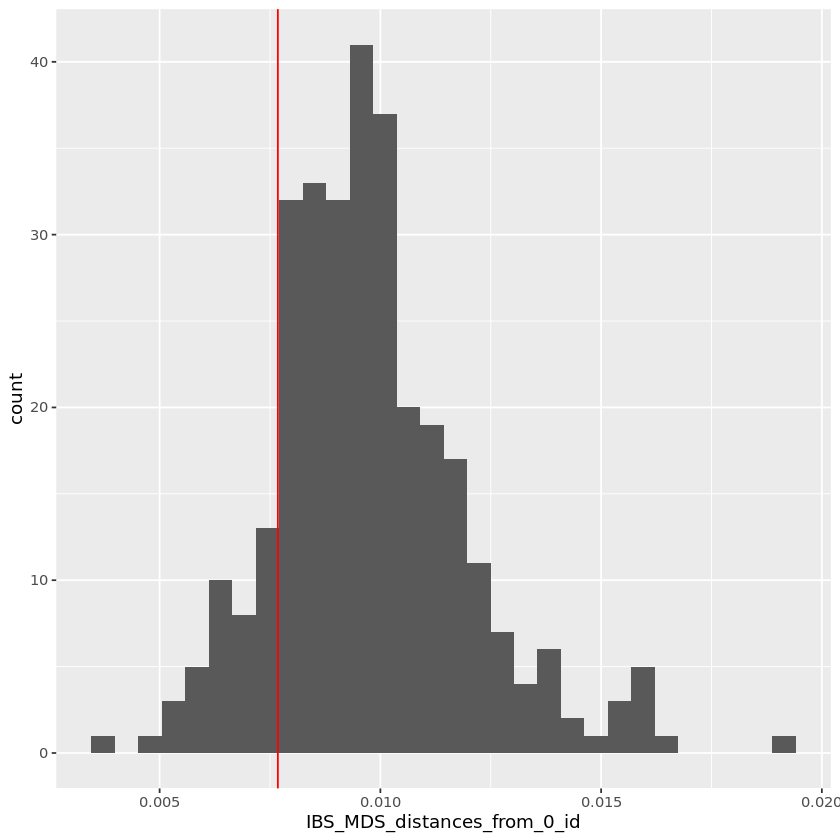

In [50]:
id=1
trd_region=IBS_MDS_distances_from_0[[300]] # this should be its own object, calculated just before

IBS_MDS_distances_from_0_id<-extracted_elements <- purrr::map(IBS_MDS_distances_from_0, id)%>%unlist()

ggplot(mapping=aes(IBS_MDS_distances_from_0_id))+
geom_histogram()+
geom_vline(xintercept = trd_region[id], color="red")

[1] 1.751058 1.920533 1.270924 1.416303 1.171043 1.395322

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


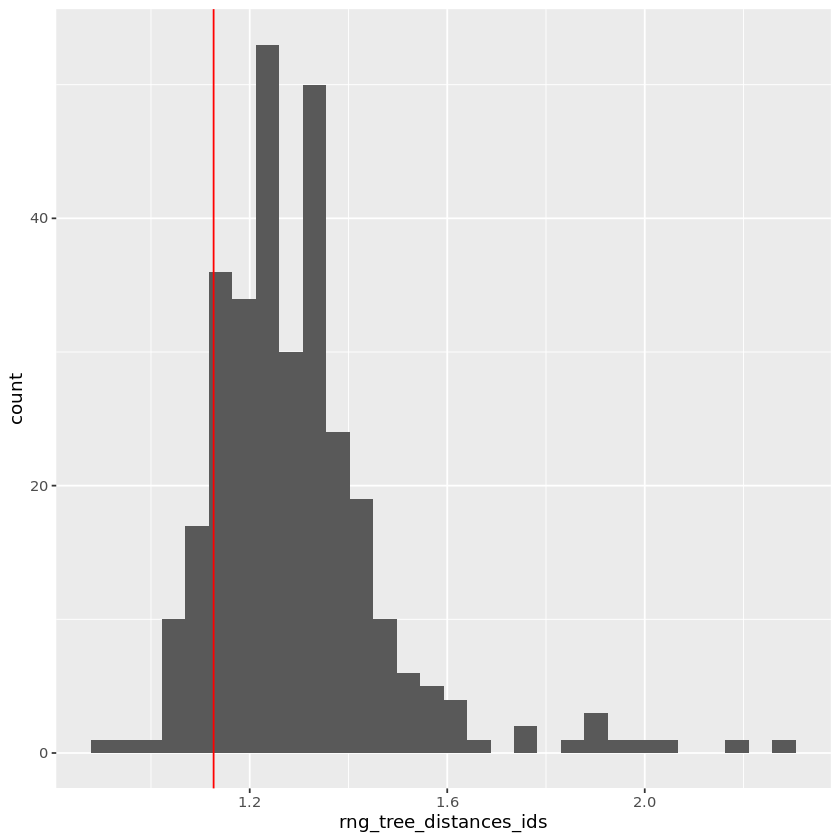

In [56]:
id=1
id2=50
extract_coord <- function(mat,x,y) {
  mat[x, y]
}

rng_tree_distances_ids<-purrr::pmap(list(rng_tree_distances, id, id2), extract_coord)%>%unlist()
trd_region=rng_tree_distances[[300]] # this should be its own object, calculated just before

head(rng_tree_distances_ids)

ggplot(mapping=aes(rng_tree_distances_ids))+
geom_histogram()+
geom_vline(xintercept = trd_region[id,id2], color="red")

In [10]:
crosses=readLines("~/data/trd/mapped_reads/TRD.vcf.gz.samples")
crosses=crosses[startsWith(crosses, "YJNRC") | startsWith(crosses, "Chris")]
crosses

[1] "ChrisC1" "ChrisC2" "ChrisC3" "ChrisC4" "ChrisC5" "ChrisC6" "ChrisC7"
 [8] "ChrisC8" "YJNRC1"  "YJNRC11" "YJNRC12" "YJNRC14" "YJNRC15" "YJNRC16"
[15] "YJNRC17" "YJNRC18" "YJNRC19" "YJNRC2"  "YJNRC20" "YJNRC21" "YJNRC22"
[22] "YJNRC23" "YJNRC24" "YJNRC25" "YJNRC26" "YJNRC27" "YJNRC29" "YJNRC3" 
[29] "YJNRC30" "YJNRC31" "YJNRC32" "YJNRC34" "YJNRC4"  "YJNRC5"  "YJNRC6" 
[36] "YJNRC7"  "YJNRC8"  "YJNRC9"

In [11]:
file_a_exists_and_is_newer_than_file_b=function(a,b){
    if(file.exists(a)){
        if(file.mtime(a)>file.mtime(b)){
            return(TRUE)
        }
    }
    return(FALSE)
}

Warning message:
"Using size for a discrete variable is not advised."


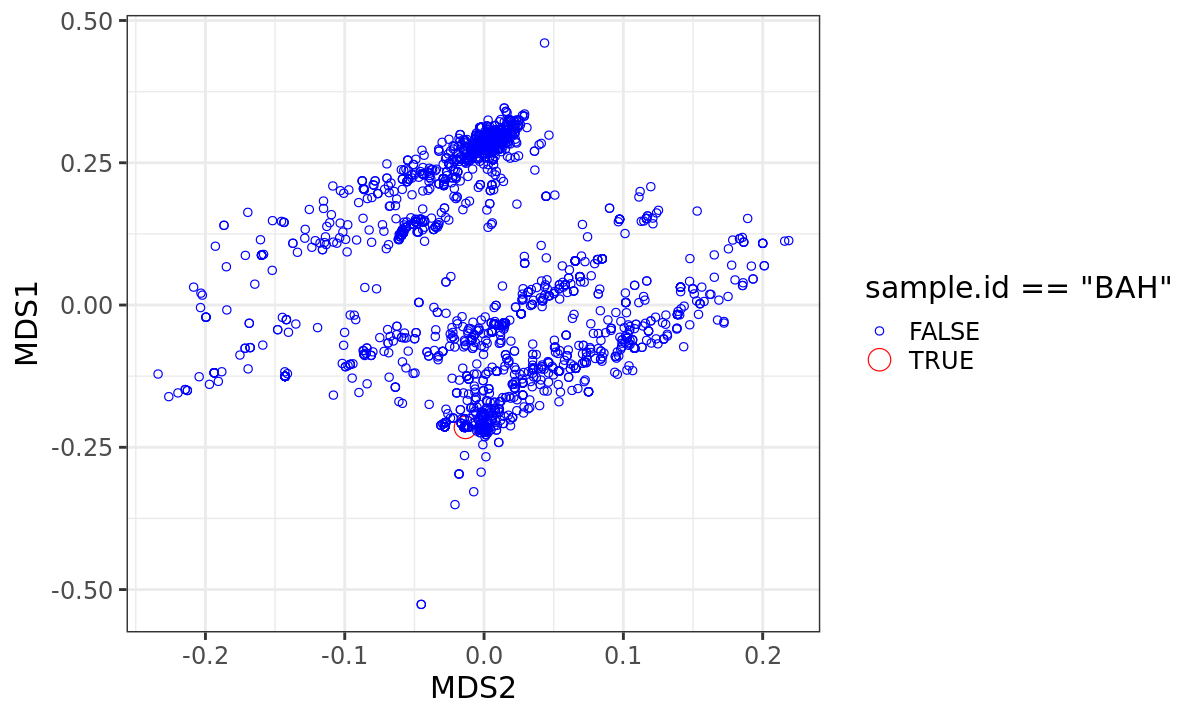

In [33]:
options(repr.plot.width=10, repr.plot.height=6)



In [41]:
crosses=c("ChrisC7")

Warning message:
"Using size for a discrete variable is not advised."
Warning message:
"Using size for a discrete variable is not advised."


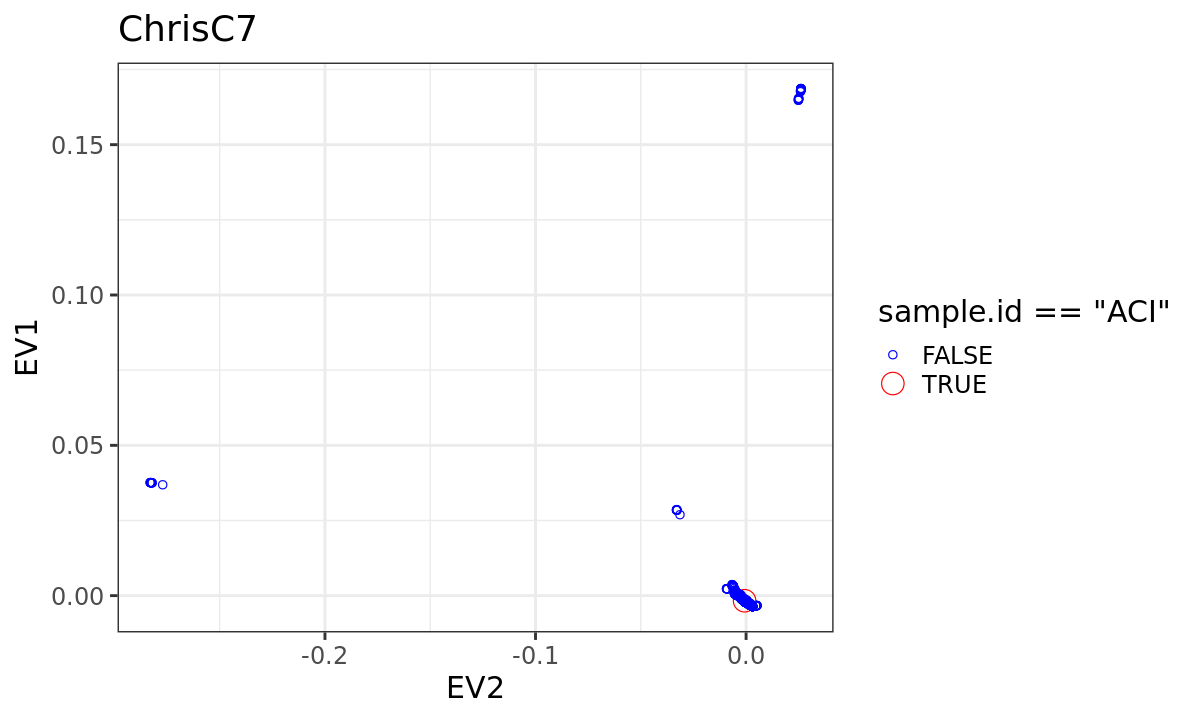

Principal Component Analysis (PCA) on genotypes:
Excluding 2,213,256 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 2,944
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 13297983
CPU capabilities: Double-Precision SSE2
Thu May  4 16:54:32 2023    (internal increment: 2616)
[==================================================] 100%, completed, 6s  
Thu May  4 16:54:38 2023    Begin (eigenvalues and eigenvectors)
Thu May  4 16:54:43 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


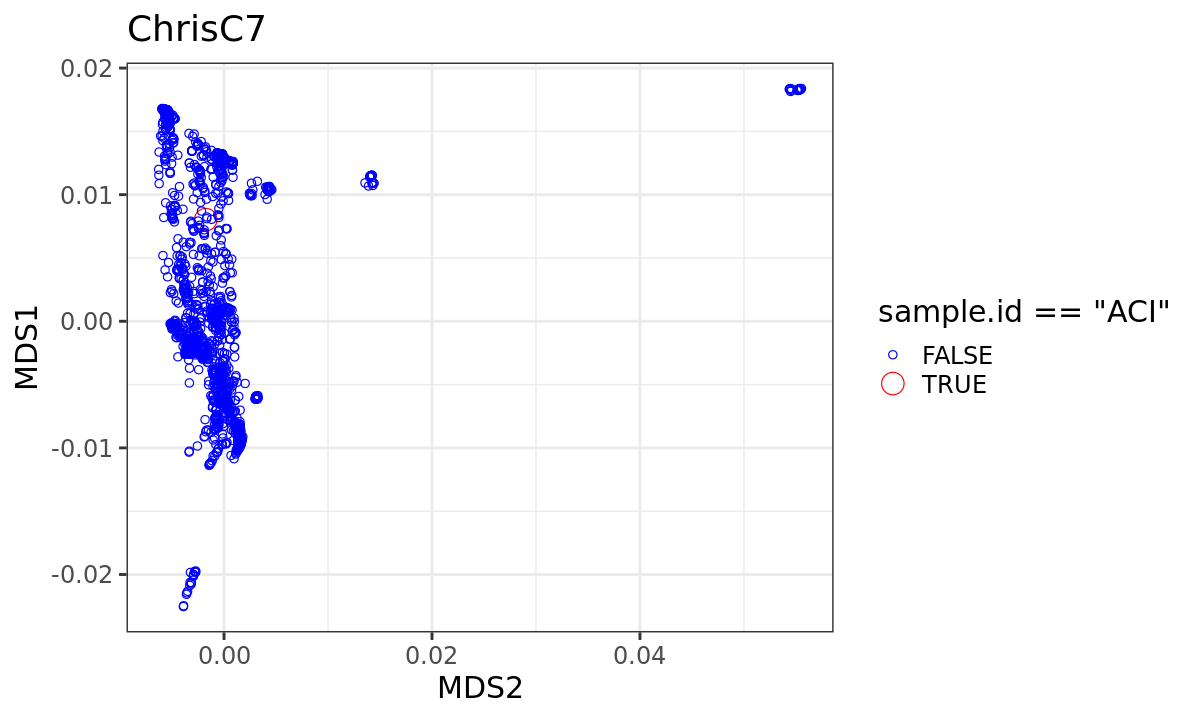

Identity-By-State (IBS) analysis on genotypes:
Excluding 2,213,256 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 2,944
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 13297983
Thu May  4 16:54:43 2023    (internal increment: 65536)
[==================================================] 100%, completed, 17s 
Thu May  4 16:55:00 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


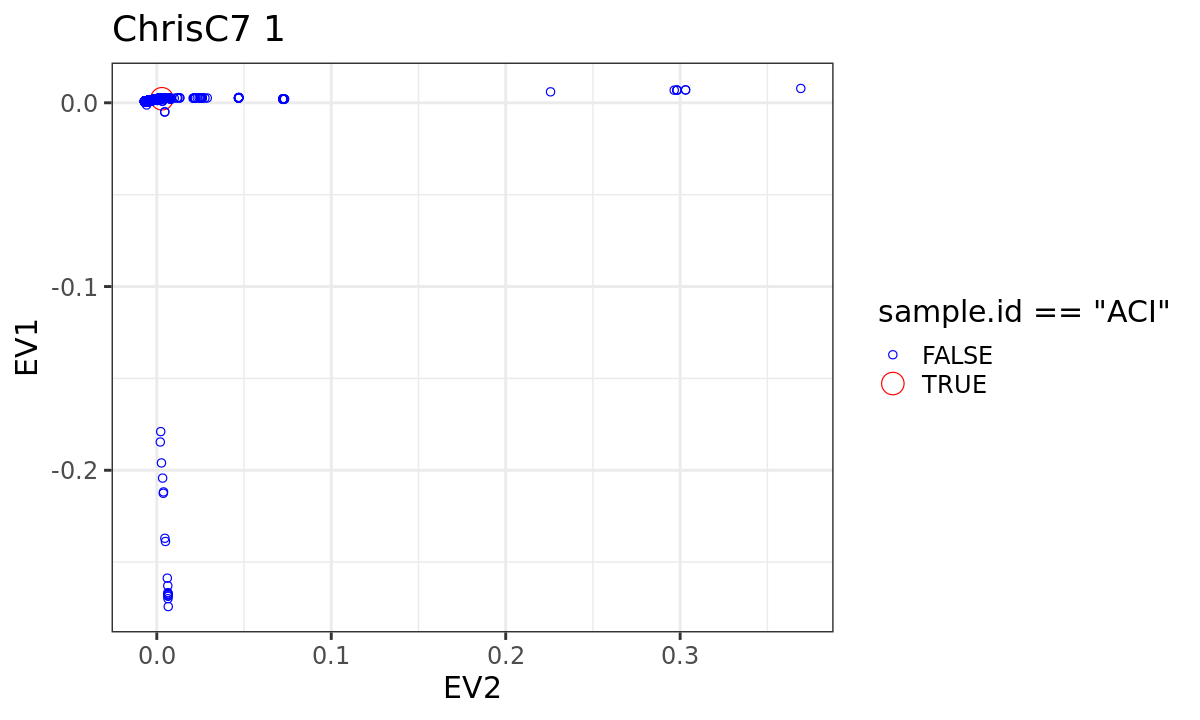

Principal Component Analysis (PCA) on genotypes:
Excluding 2,210,740 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 5,460
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 23855895
CPU capabilities: Double-Precision SSE2
Thu May  4 16:55:04 2023    (internal increment: 2616)
[==================================================] 100%, completed, 11s 
Thu May  4 16:55:15 2023    Begin (eigenvalues and eigenvectors)
Thu May  4 16:55:19 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


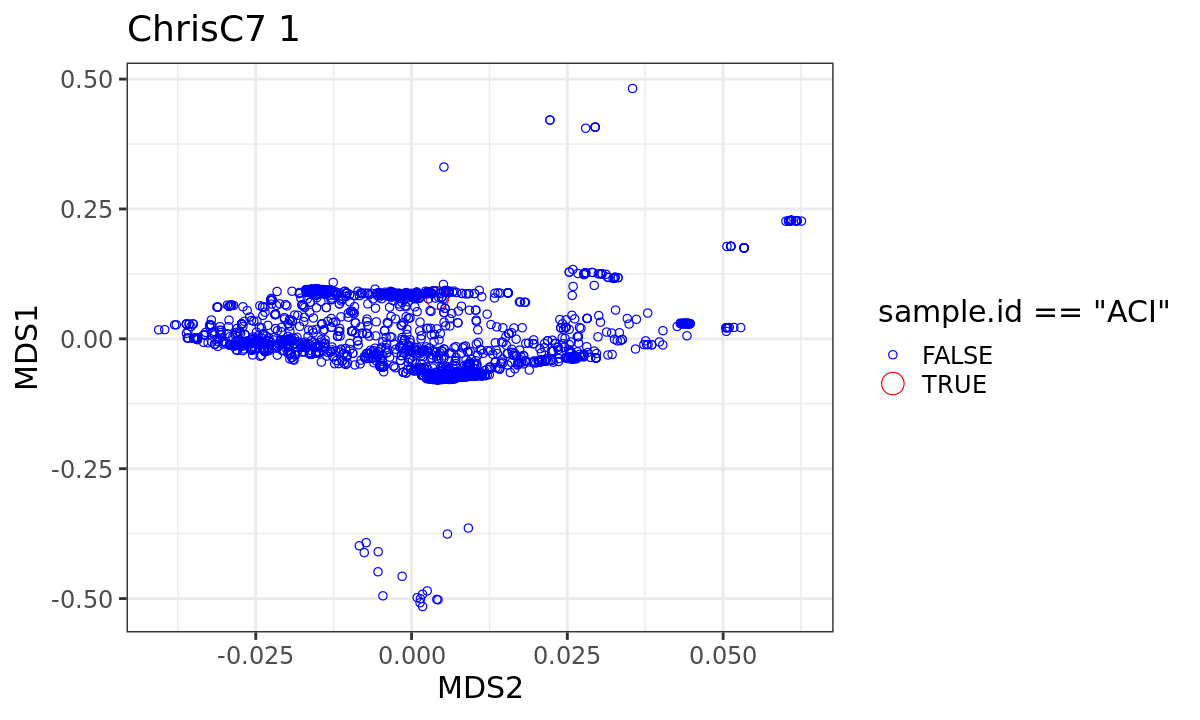

Identity-By-State (IBS) analysis on genotypes:
Excluding 2,210,740 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 5,460
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 23855895
Thu May  4 16:55:20 2023    (internal increment: 65536)
[==================================================] 100%, completed, 17s 
Thu May  4 16:55:37 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


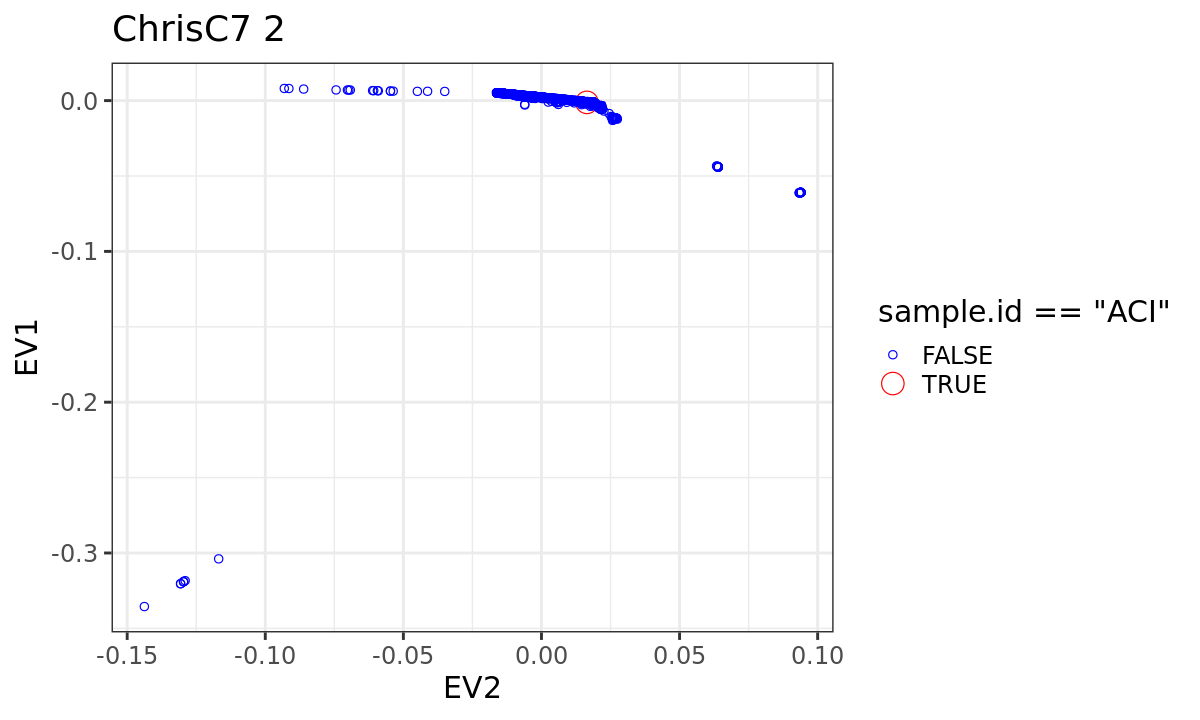

Principal Component Analysis (PCA) on genotypes:
Excluding 2,215,176 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 1,024
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 4349797
CPU capabilities: Double-Precision SSE2
Thu May  4 16:55:42 2023    (internal increment: 2616)
[==================================================] 100%, completed, 3s  
Thu May  4 16:55:45 2023    Begin (eigenvalues and eigenvectors)
Thu May  4 16:55:49 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


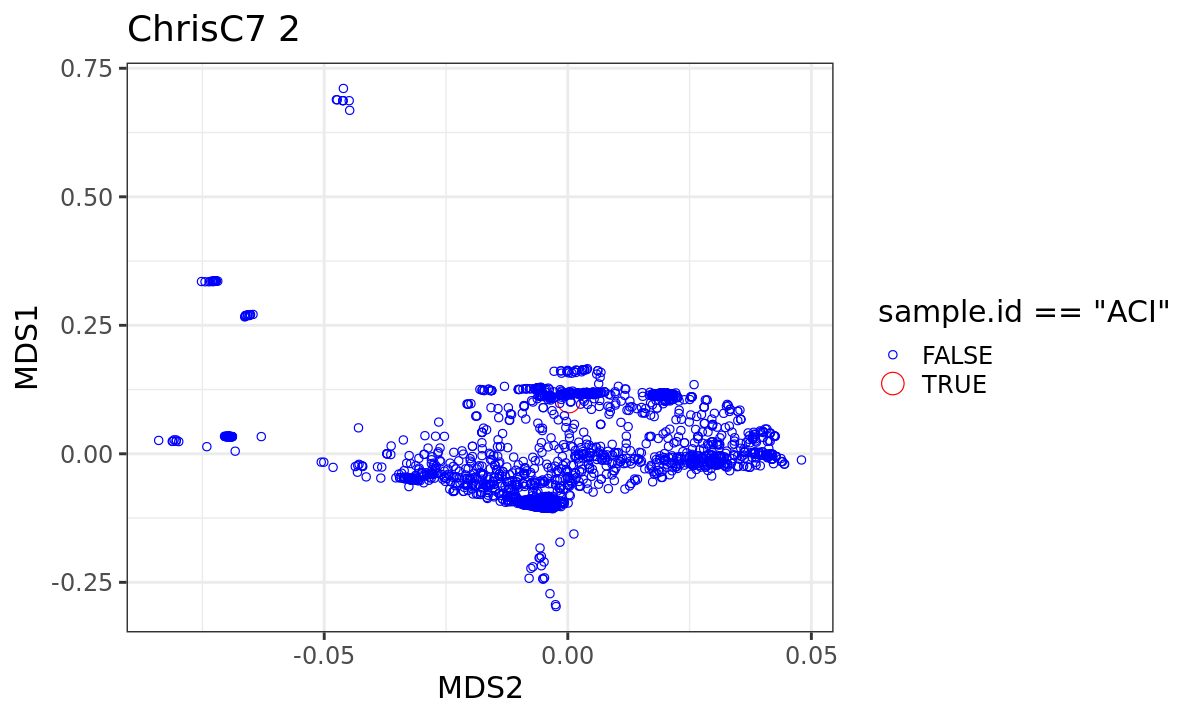

Identity-By-State (IBS) analysis on genotypes:
Excluding 2,215,176 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 1,024
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 4349797
Thu May  4 16:55:50 2023    (internal increment: 65536)
[==================================================] 100%, completed, 17s 
Thu May  4 16:56:07 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


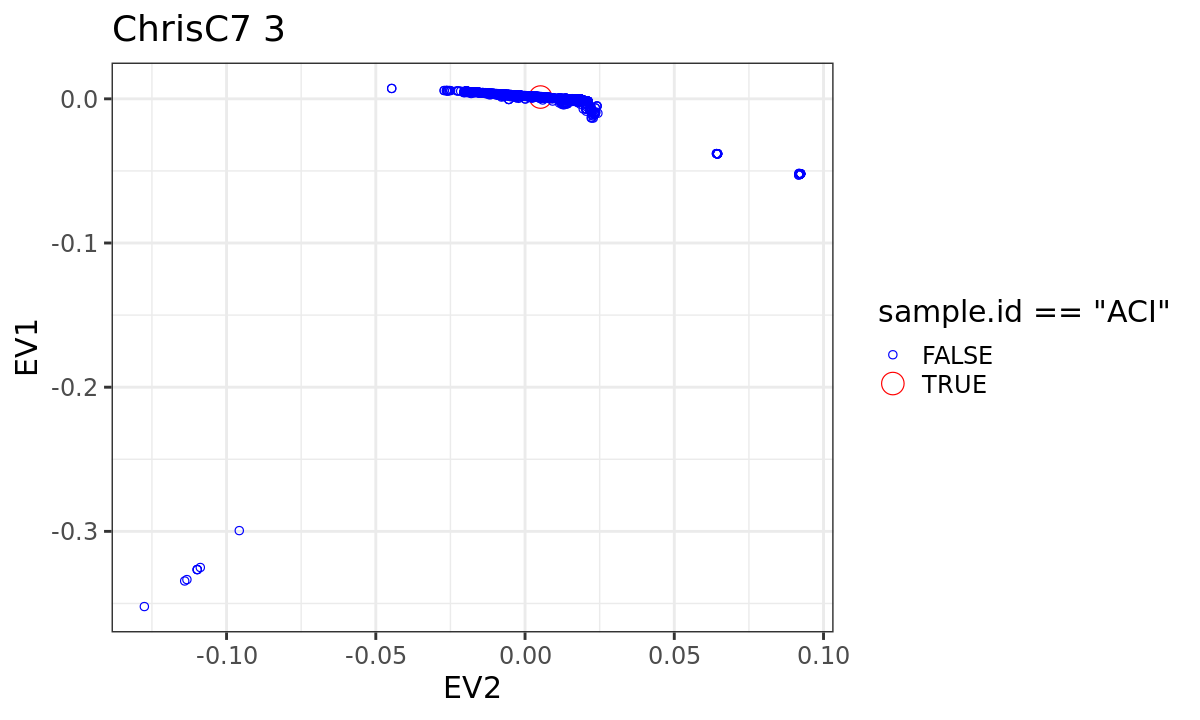

Principal Component Analysis (PCA) on genotypes:
Excluding 2,215,418 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 782
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 3296859
CPU capabilities: Double-Precision SSE2
Thu May  4 16:56:11 2023    (internal increment: 2616)
[==================================================] 100%, completed, 4s  
Thu May  4 16:56:15 2023    Begin (eigenvalues and eigenvectors)
Thu May  4 16:56:19 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


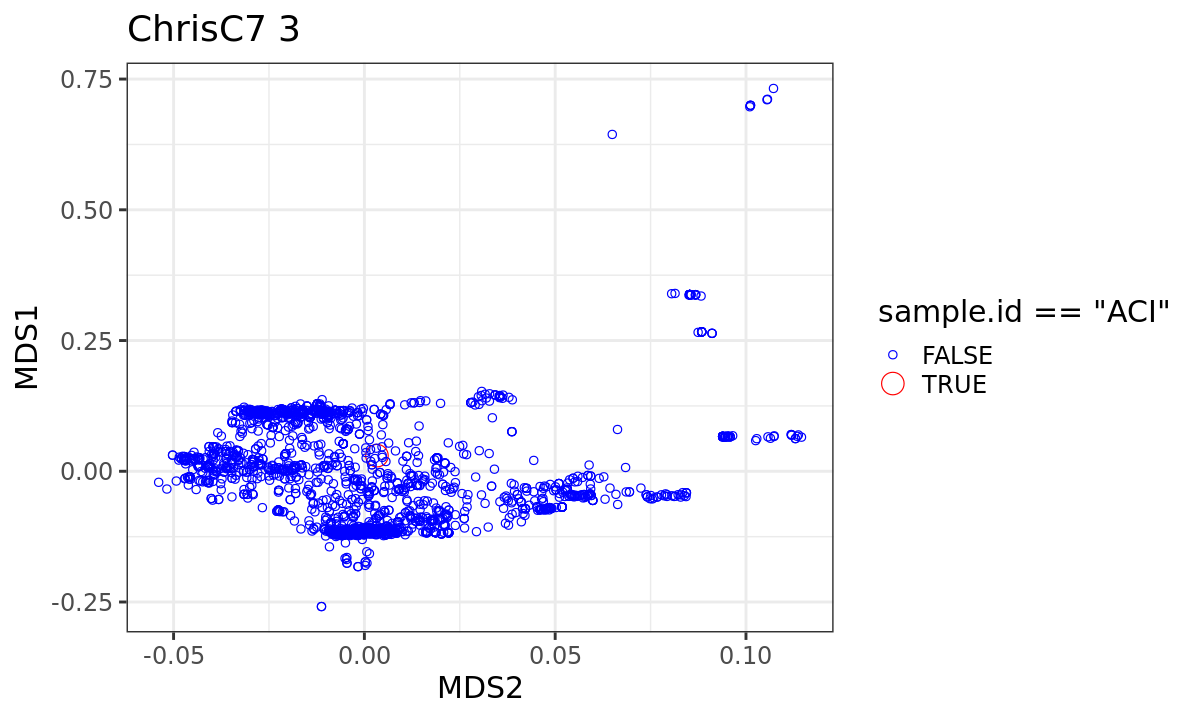

Identity-By-State (IBS) analysis on genotypes:
Excluding 2,215,418 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 782
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 3296859
Thu May  4 16:56:19 2023    (internal increment: 65536)
[==================================================] 100%, completed, 17s 
Thu May  4 16:56:36 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


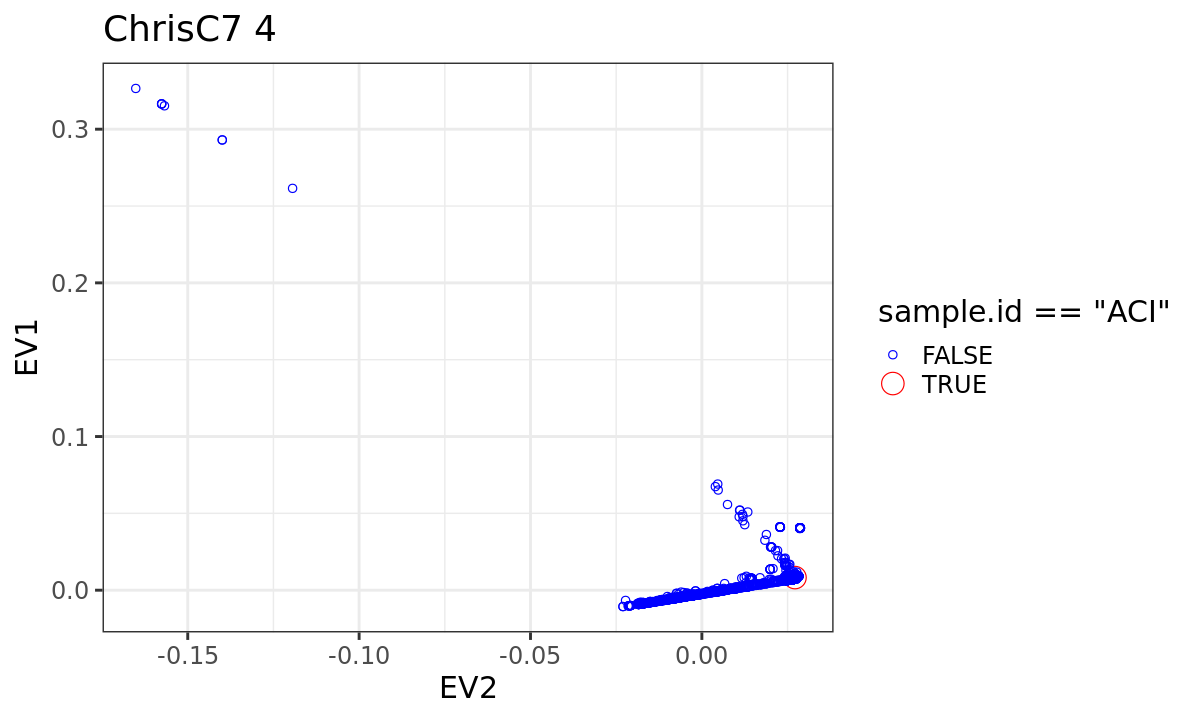

Principal Component Analysis (PCA) on genotypes:
Excluding 2,214,563 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 1,637
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 6578222
CPU capabilities: Double-Precision SSE2
Thu May  4 16:56:40 2023    (internal increment: 2616)
[==================================================] 100%, completed, 4s  
Thu May  4 16:56:44 2023    Begin (eigenvalues and eigenvectors)
Thu May  4 16:56:48 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


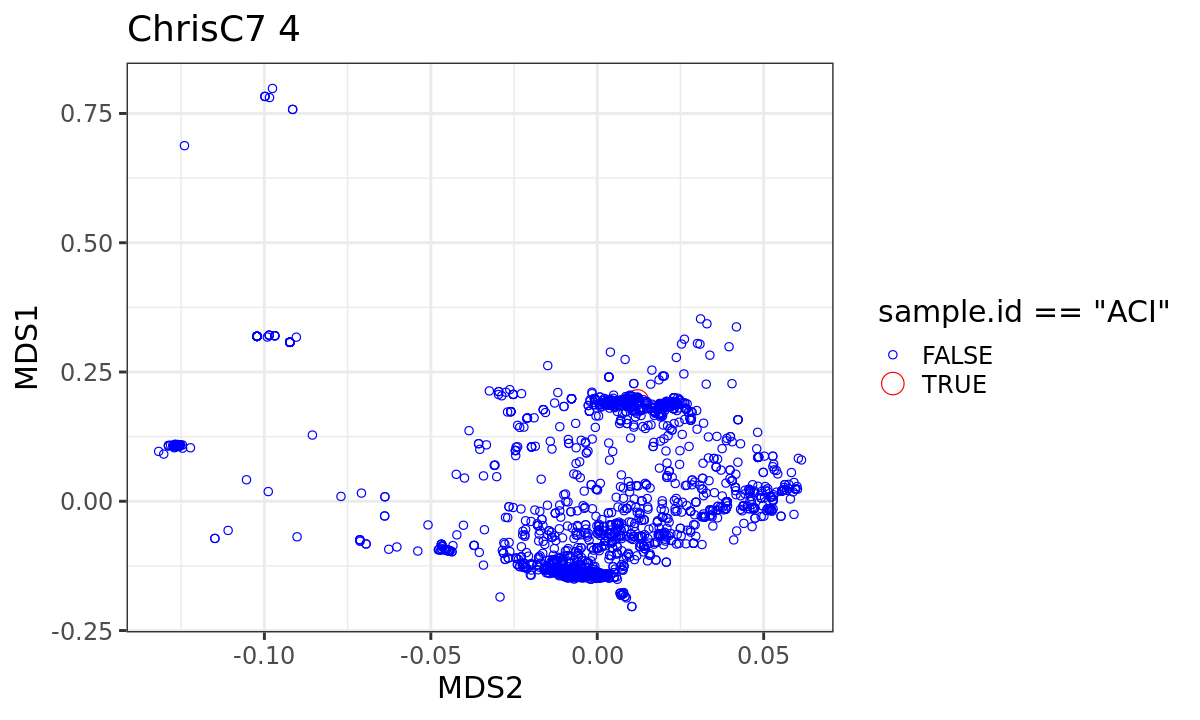

Identity-By-State (IBS) analysis on genotypes:
Excluding 2,214,563 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 1,637
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 6578222
Thu May  4 16:56:49 2023    (internal increment: 65536)
[==================================================] 100%, completed, 20s 
Thu May  4 16:57:10 2023    Done.


Warning message:
"Using size for a discrete variable is not advised."


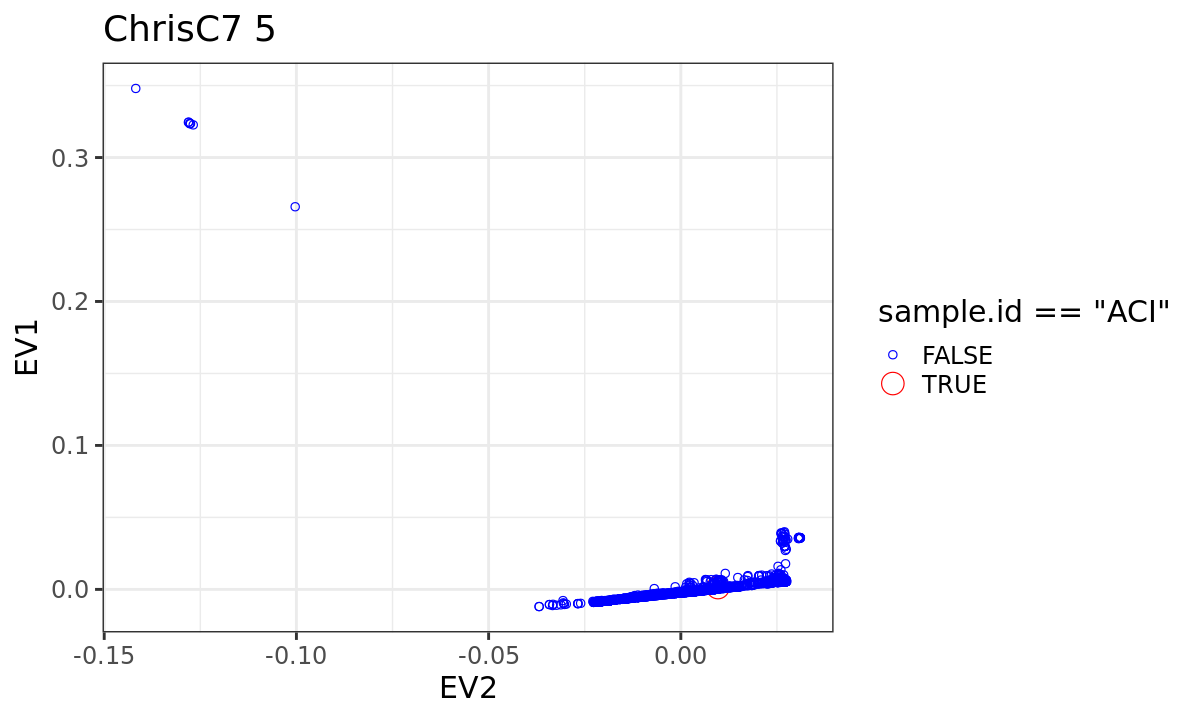

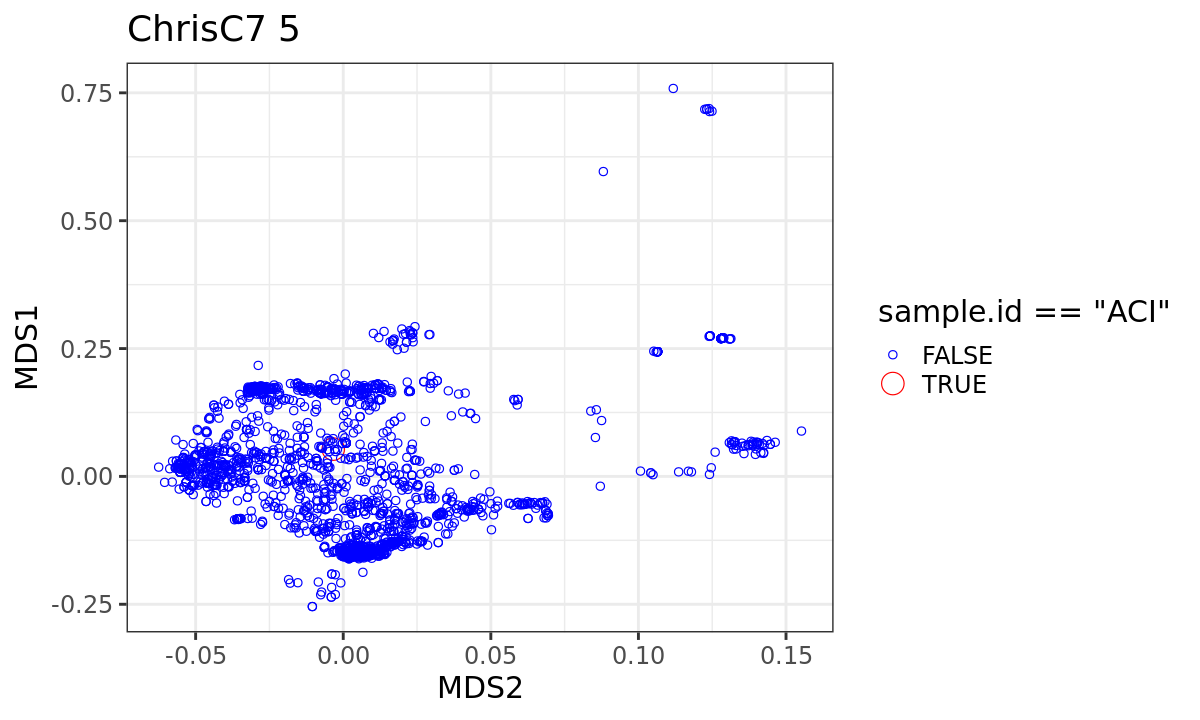

In [42]:
for(c in crosses){
    TRD_regions_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz")
    AS_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")
    TRD_file<-paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz")
    
        if(!file_a_exists_and_is_newer_than_file_b(TRD_file,"~/data/trd/mapped_reads/TRD.vcf.gz")){
        print(paste0(c, " TRD file does not exist or is not newer than TRD.vcf.gz"))
        next
    }
    
    if(!file_a_exists_and_is_newer_than_file_b(TRD_regions_file,TRD_file)){
        print(paste0(c, " has no TRD regions or no up-to-date ones"))
        next
    }
    if(!file_a_exists_and_is_newer_than_file_b(AS_file,TRD_file)){
        print(paste0(c, " has no or no updated allele sharing file"))
        next
    }
    p_global<-ggplot(tab_global, aes(EV2,EV1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c))
    print(p_global)
    
    p_ibs_global<-ggplot(tab_ibs_global, aes(MDS2,MDS1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c))
    print(p_ibs_global)
    
    AS=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))

    TRD=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))

    TRD_loci=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))

    for(i in 1:nrow(TRD_loci)){
        if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
            stop("chr overlapping TRD")
        }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)

        snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))%in%TRD_subset$pos & 
                     paste0("chromosome",read.gdsn(index.gdsn(genofile, "snp.chromosome"))) == TRD_loci$chr_start[i])

        pca_TRD <- snpgdsPCA(genofile, num.thread=1, snp.id = snpset)

        pca_TRD.percent <- pca_TRD$varprop*100

        tab <- data.frame(sample.id = pca_TRD$sample.id,
            EV1 = pca_TRD$eigenvect[,1],    # the first eigenvector
            EV2 = pca_TRD$eigenvect[,2],    # the second eigenvector
            stringsAsFactors = FALSE)

        p<-ggplot(tab, aes(EV2,EV1, color=sample.id=="ACI",size=sample.id=="ACI"))+
        geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c,i))
        print(p)
        
        
        
        
        
        
        ibs <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
loc <- cmdscale(1 - ibs$ibs, k = 2)
x <- loc[, 1]; y <- loc[, 2]

tab_ibs <- data.frame(sample.id = ibs$sample.id,
            MDS1 = x,    # the first eigenvector
            MDS2 = y,    # the second eigenvector
            stringsAsFactors = FALSE)


p_ibs<-ggplot(tab_ibs, aes(MDS2,MDS1, color=sample.id=="ACI",size=sample.id=="ACI"))+
geom_point(shape=1)+theme_bw(18)+scale_color_manual(values=c("TRUE"="red","FALSE"="blue"))+ggtitle(paste(c,i))
        
        print(p_ibs)
        

    }

}